In [ ]:
pip install opencv-python pandas seaborn

Note: you may need to restart the kernel to use updated packages.


### Setup

In [1]:
import pandas as pd
from IPython.display import display 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import os
import seaborn as sns
from datetime import datetime

### Creating datapaths

##### Vídeo 1

In [2]:
path= r"G:\Meu Drive\Meu projeto\csv_analise\top\neutro\Fiona_d17_teste_door(object2)_1DLC_Resnet50_top_viewMay29shuffle1_snapshot_110.csv"
df = pd.read_csv(path, header=[1, 2])

video_path = r"G:\Meu Drive\Meu projeto\csv_analise\top\neutro\Fiona_d17_teste_door(object2)_1.mp4"
cap = cv2.VideoCapture(video_path) 

stim_timestamps = r"G:\Meu Drive\Meu projeto\csv_analise\top\neutro\Fiona_d17_teste_door(object2)_stim_ON_OFF_timestamps.csv"
stim_df = pd.read_csv(stim_timestamps, header=[0])

In [536]:
stim_df

,stim_ON,stim_OFF
0,180.000683,200.001022
1,360.001591,380.001884
2,540.002603,560.003267
3,720.003899,740.003933


### Dataframe segmentation

In [3]:
def get_seg(df, on, off, fps=30, i=0):
    start_sec = on[i]
    end_sec = on[i]+5
        
    start_frame = start_sec * fps
    end_frame = end_sec * fps
        
    segmento = df[(df.index >= start_frame) & (df.index <= end_frame)]

    return segmento

##### Baseline

In [4]:
baseline_on = stim_df['stim_ON'] - 5 
baseline_off = stim_df['stim_ON']    

baseline_df = pd.DataFrame({
    'baseline_ON': baseline_on,
    'baseline_OFF': baseline_off
})

display(baseline_df)

,baseline_ON,baseline_OFF
0,175.000683,180.000683
1,355.001591,360.001591
2,535.002603,540.002603
3,715.003899,720.003899


In [5]:
baseline1 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=0)
baseline2 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=1)
baseline3 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=2)
baseline4 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=3)

baseline1_sorted = baseline1.sort_index()
baseline2_sorted = baseline2.sort_index()
baseline3_sorted = baseline3.sort_index()
baseline4_sorted = baseline4.sort_index()

stims_array = np.stack([
    baseline1_sorted.values,
    baseline2_sorted.values,
    baseline3_sorted.values,
    baseline4_sorted.values
])

df_seg_baseline1 = pd.DataFrame(stims_array[0], columns=baseline1_sorted.columns)
df_seg_baseline2 = pd.DataFrame(stims_array[1], columns=baseline2_sorted.columns)
df_seg_baseline3 = pd.DataFrame(stims_array[2], columns=baseline3_sorted.columns)
df_seg_baseline4 = pd.DataFrame(stims_array[3], columns=baseline4_sorted.columns)

df_seg_baseline = [
    df_seg_baseline1.copy(),
    df_seg_baseline2.copy(),
    df_seg_baseline3.copy(),
    df_seg_baseline4.copy()
]



##### Stim window

In [6]:
stim1 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=0)
stim2 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=1)
stim3 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=2)
stim4 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=3)

stim1_sorted = stim1.sort_index()
stim2_sorted = stim2.sort_index()
stim3_sorted = stim3.sort_index()
stim4_sorted = stim4.sort_index()

stims_array = np.stack([
    stim1_sorted.values,
    stim2_sorted.values,
    stim3_sorted.values,
    stim4_sorted.values
])

df_seg_stim1 = pd.DataFrame(stims_array[0], columns=baseline1_sorted.columns)
df_seg_stim2 = pd.DataFrame(stims_array[1], columns=baseline2_sorted.columns)
df_seg_stim3 = pd.DataFrame(stims_array[2], columns=baseline3_sorted.columns)
df_seg_stim4 = pd.DataFrame(stims_array[3], columns=baseline4_sorted.columns)

df_seg_stim = [
    df_seg_stim1.copy(),
    df_seg_stim2.copy(),
    df_seg_stim3.copy(),
    df_seg_stim4.copy()
]


### Box area selection

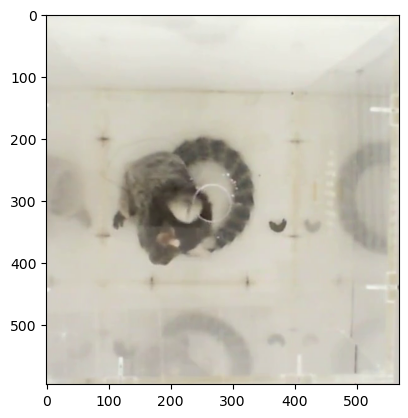

In [7]:
cap = cv2.VideoCapture(video_path) 
numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
chosenFrameIdx = np.random.randint(1, high=numOfFrames)
cap.set(cv2.CAP_PROP_POS_FRAMES, chosenFrameIdx)
res, chosenFrame = cap.read()

original_height, original_width, _ = chosenFrame.shape
display_max_width = 700
ratio = display_max_width / original_width
display_height = int(original_height * ratio)

frame_for_selection = cv2.resize(chosenFrame, (display_max_width, display_height))

roi_small = cv2.selectROI('Select the arena, then press space and enter', frame_for_selection) 

x_scale = original_width / display_max_width
y_scale = original_height / display_height

roi_original_scale = (
    int(roi_small[0] * x_scale),
    int(roi_small[1] * y_scale),
    int(roi_small[2] * x_scale),
    int(roi_small[3] * y_scale)
)

roi_cropped = chosenFrame[int(roi_original_scale[1]):int(roi_original_scale[1]+roi_original_scale[3]), int(roi_original_scale[0]):int(roi_original_scale[0]+roi_original_scale[2])]
plt.imshow(cv2.cvtColor(roi_cropped, cv2.COLOR_BGR2RGB))
plt.show()

cv2.waitKey(0) 
cv2.destroyAllWindows()

arenaSide = (roi_original_scale[2] + roi_original_scale[3]) / 2 
xThresholdLeft = roi_original_scale[0]
xThresholdRight = roi_original_scale[0] + arenaSide
yThresholdUp = roi_original_scale[1]
yThresholdDown = roi_original_scale[1] + arenaSide

### Convert pixel to cm

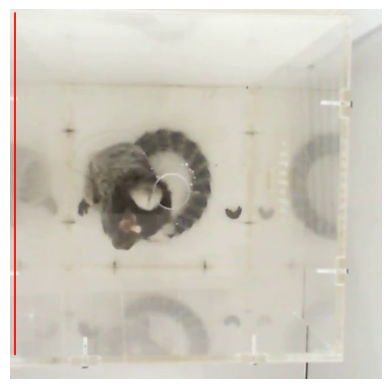

Pixels per cm: 22.384615384615383


In [8]:
py1 = yThresholdDown 
py2 = yThresholdUp
px = xThresholdLeft

frame_with_line = chosenFrame.copy()
cv2.line(frame_with_line, (px, int(py1)), (px, int(py2)), (0, 0, 255), 2)  
frame_with_line_rgb = cv2.cvtColor(frame_with_line, cv2.COLOR_BGR2RGB)
plt.imshow(frame_with_line_rgb)
plt.axis('off') 
plt.show()

pix_per_cm = (py1-py2) / 26 # 26 cm é a distância entre os dois pontos
print(f"Pixels per cm: {pix_per_cm}")

### Filter coordinates

##### Function

In [9]:
def process_tracking_data(df, bodyparts, thresholds, pix_per_cm, window_size=59):
    df_processed = df.copy()

    for part in bodyparts:
        x_coords = df_processed[(part, 'x')]
        y_coords = df_processed[(part, 'y')]
        x_filt = np.where((x_coords >= thresholds['x_min']) & (x_coords <= thresholds['x_max']), x_coords, np.nan)
        y_filt = np.where((y_coords >= thresholds['y_min']) & (y_coords <= thresholds['y_max']), y_coords, np.nan)

        df_processed[(part, 'x')] = x_filt / pix_per_cm
        df_processed[(part, 'y')] = y_filt / pix_per_cm

    columns_to_check = [(part, coord) for part in bodyparts for coord in ['x', 'y']]
    df_processed.dropna(subset=columns_to_check, inplace=True)

    df_smoothed = df_processed[columns_to_check].rolling(window=window_size, min_periods=1, center=True).mean()

    return df_smoothed

In [10]:
trials = [0, 1, 2, 3]
bodyparts = ['body', 'head', 'nose']
thresholds = {
    'x_min': xThresholdLeft, 
    'x_max': xThresholdRight,
    'y_min': yThresholdUp,
    'y_max': yThresholdDown
} 

processed_trials = []

for i in trials:
    df_base_processed = process_tracking_data(
        df=df_seg_baseline[i],
        bodyparts=bodyparts,
        thresholds=thresholds,
        pix_per_cm=pix_per_cm,
        window_size=20
    )
    df_base_processed['trial'] = i
    df_base_processed['period'] = 'baseline'
    
    df_stim_processed = process_tracking_data(
        df=df_seg_stim[i],
        bodyparts=bodyparts,
        thresholds=thresholds,
        pix_per_cm=pix_per_cm,
        window_size=20
    )

    df_stim_processed['trial'] = i
    df_stim_processed['period'] = 'stimulus'
    
    processed_trials.append(df_base_processed)
    processed_trials.append(df_stim_processed)

df_final = pd.concat(processed_trials, ignore_index=True)

df_t1= df_final[df_final['trial'] == 0]
df_t2= df_final[df_final['trial'] == 1]
df_t3= df_final[df_final['trial'] == 2]
df_t4= df_final[df_final['trial'] == 3]

display(df_t3)

body                  head                 nose            trial  \
            x          y          x          y         x          y         
600  5.844008   6.855688   4.789550   8.442011  5.635167  10.270738     2   
601  5.765878   6.891213   4.813449   8.423005  5.637825  10.236387     2   
602  5.889815   6.847218   4.840821   8.408809  5.646867  10.213942     2   
603  5.996405   6.811301   4.871612   8.392600  5.664438  10.192065     2   
604  5.929478   6.840949   4.897935   8.378683  5.679551  10.173284     2   
..        ...        ...        ...        ...       ...        ...   ...   
895  7.423738  11.089845   9.906342  13.121898  9.365152  14.286582     2   
896  7.429880  11.288481  10.025289  13.214380  9.451671  14.337089     2   
897  7.478192  11.479940  10.139175  13.308304  9.533673  14.371898     2   
898  7.539345  11.687753  10.252670  13.395711  9.624649  14.406668     2   
899  7.420886  11.752656  10.363875  13.478985  9.702877  14.431998     2   

       period  
               
600  baseline  
601  baseline  
602  baseline  
603  baseline  
604  baseline  
..        ...  
895  stimulus  
896  stimulus  
897  stimulus  
898  stimulus  
899  stimulus  

[300 rows x 8 columns]

In [496]:
df_t1[df_t1['period'] == 'baseline'][('head', 'x')]

0      4.594335
1      4.594603
2      4.592312
3      4.591426
4      4.590285
         ...   
145    6.837025
146    6.830760
147    6.824090
148    6.816023
149    6.807250
Name: (head, x), Length: 150, dtype: float64

### Metrics

##### Functions

In [12]:
def angles(head_x, head_y, nose_x, nose_y, fps=30):
    dx = nose_x - head_x
    dy = nose_y - head_y
    angles_rad = np.arctan2(dy, dx)
    angles_deg = (np.degrees(angles_rad) + 360) % 360
    count_frames = np.sum((angles_deg >= 0) & (angles_deg <= 180))
    seconds = count_frames / fps
    return seconds

def total_displacement(df, bodypart='body'):
    x = df[(bodypart, 'x')].values
    y = df[(bodypart, 'y')].values
    dx = np.diff(x)
    dy = np.diff(y)
    displacement = np.sqrt(dx**2 + dy**2)
    return np.nansum(displacement)

def ang_vel(head_x, head_y, nose_x, nose_y, fps, limiar_velocidade=90.0):
    dx = nose_x - head_x
    dy = nose_y - head_y
    
    ang_rad = np.arctan2(dy, dx)
    
    delta_ang = np.diff(ang_rad)
    delta_ang = np.where(delta_ang > np.pi, delta_ang - 2 * np.pi, delta_ang)
    delta_ang = np.where(delta_ang < -np.pi, delta_ang + 2 * np.pi, delta_ang)
    
    vrad_s = delta_ang * fps
    vrad_s = np.insert(vrad_s, 0, 0)
    vdeg_s = np.degrees(vrad_s)
    
    vdeg_s_filtrada = np.where(np.abs(vdeg_s) > limiar_velocidade, 0, vdeg_s)
    
    return np.abs(vdeg_s_filtrada)

def calcular_velocidade_media(df, bodypart='body', fps=30):
    x = df[(bodypart, 'x')].values
    y = df[(bodypart, 'y')].values
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.sqrt(dx**2 + dy**2)
    tempo_total = len(x) / fps
    velocidade_media = np.nansum(dist) / tempo_total
    return velocidade_media


##### Resultados

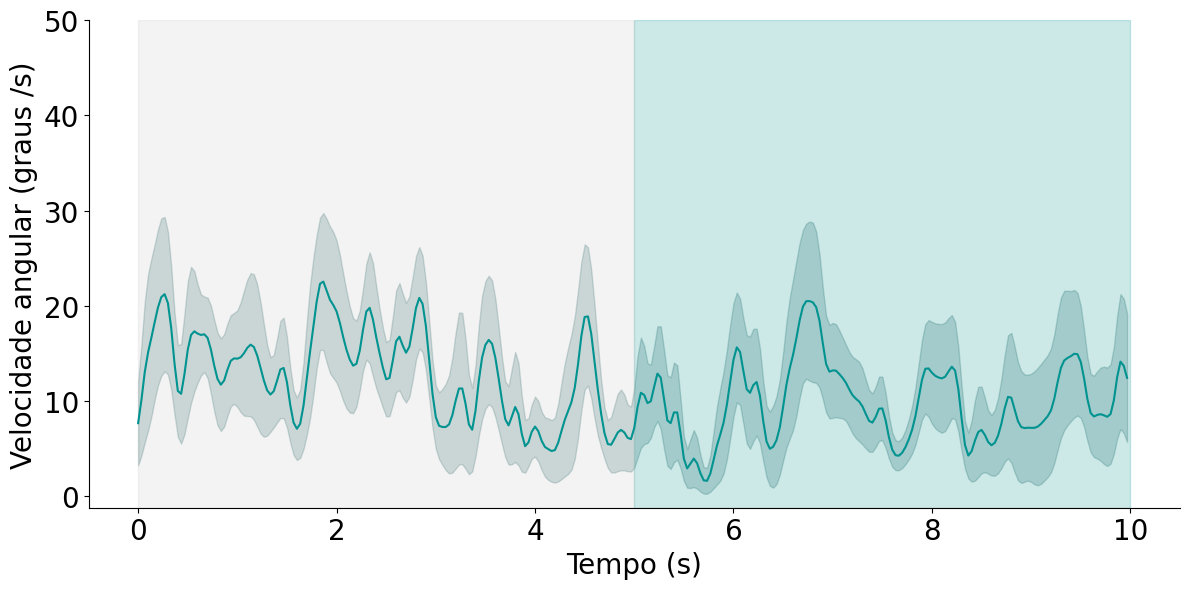

In [15]:
from scipy.ndimage import gaussian_filter1d

head_x_t1 = df_t1[('head', 'x')]
head_y_t1 = df_t1[('head', 'y')]
nose_x_t1 = df_t1[('nose', 'x')]
nose_y_t1 = df_t1[('nose', 'y')]

vel_ang1 = ang_vel(head_x_t1, head_y_t1, nose_x_t1, nose_y_t1, fps=30, limiar_velocidade=50.0)

head_x_t2 = df_t2[('head', 'x')]
head_y_t2 = df_t2[('head', 'y')]        
nose_x_t2 = df_t2[('nose', 'x')]
nose_y_t2 = df_t2[('nose', 'y')]

vel_ang2 = ang_vel(head_x_t2, head_y_t2, nose_x_t2, nose_y_t2, fps=30, limiar_velocidade=50.0)

head_x_t3 = df_t3[('head', 'x')]
head_y_t3 = df_t3[('head', 'y')]    
nose_x_t3 = df_t3[('nose', 'x')]
nose_y_t3 = df_t3[('nose', 'y')]

vel_ang3 = ang_vel(head_x_t3, head_y_t3, nose_x_t3, nose_y_t3, fps=30, limiar_velocidade=50.0)

head_x_t4 = df_t4[('head', 'x')]
head_y_t4 = df_t4[('head', 'y')]    
nose_x_t4 = df_t4[('nose', 'x')]
nose_y_t4 = df_t4[('nose', 'y')]

vel_ang4 = ang_vel(head_x_t4, head_y_t4, nose_x_t4, nose_y_t4, fps=30, limiar_velocidade=50.0)

vel_ang_mean = np.nanmean([vel_ang1, vel_ang2, vel_ang3, vel_ang4], axis=0)
vel_ang_mean_erro = np.nanstd([vel_ang1, vel_ang2, vel_ang3, vel_ang4], axis=0) / np.sqrt(4)

vel_angular = gaussian_filter1d(vel_ang_mean, sigma=1.5)
vel_ang_erro = gaussian_filter1d(vel_ang_mean_erro, sigma=1.5)

tempo = np.arange(len(vel_angular)) / 30  # Convertendo para segundos

plt.figure(figsize=(12, 6))
plt.plot(tempo, vel_angular, color="#009390")
plt.fill_between(tempo, vel_angular - vel_ang_erro, vel_angular + vel_ang_erro, color="#014847", alpha=0.2, label='Erro padrão')
plt.axvspan(5, 10, color="#009390", alpha=0.2, label='Estímulo')
plt.axvspan(0, 5, color="#C6C6C6FF", alpha=0.2, label='Basal')
plt.xlabel('Tempo (s)', fontsize=20)
plt.ylabel('Velocidade angular (graus /s)', fontsize=20)
plt.yticks([0, 10, 20, 30, 40, 50], fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout()

# Remove as bordas do gráfico, mantendo apenas os eixos
ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()


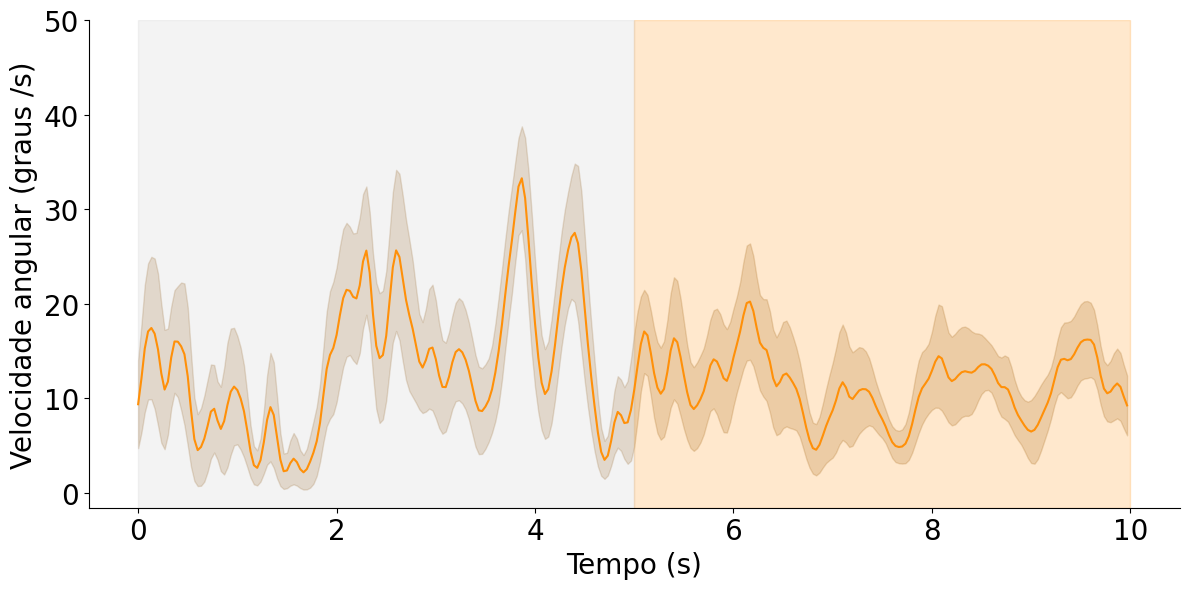

In [534]:
from scipy.ndimage import gaussian_filter1d

head_x_t1 = df_t1[('head', 'x')]
head_y_t1 = df_t1[('head', 'y')]
nose_x_t1 = df_t1[('nose', 'x')]
nose_y_t1 = df_t1[('nose', 'y')]

vel_ang1 = ang_vel(head_x_t1, head_y_t1, nose_x_t1, nose_y_t1, fps=30, limiar_velocidade=50.0)

head_x_t2 = df_t2[('head', 'x')]
head_y_t2 = df_t2[('head', 'y')]        
nose_x_t2 = df_t2[('nose', 'x')]
nose_y_t2 = df_t2[('nose', 'y')]

vel_ang2 = ang_vel(head_x_t2, head_y_t2, nose_x_t2, nose_y_t2, fps=30, limiar_velocidade=50.0)

head_x_t3 = df_t3[('head', 'x')]
head_y_t3 = df_t3[('head', 'y')]    
nose_x_t3 = df_t3[('nose', 'x')]
nose_y_t3 = df_t3[('nose', 'y')]

vel_ang3 = ang_vel(head_x_t3, head_y_t3, nose_x_t3, nose_y_t3, fps=30, limiar_velocidade=50.0)

head_x_t4 = df_t4[('head', 'x')]
head_y_t4 = df_t4[('head', 'y')]    
nose_x_t4 = df_t4[('nose', 'x')]
nose_y_t4 = df_t4[('nose', 'y')]

vel_ang4 = ang_vel(head_x_t4, head_y_t4, nose_x_t4, nose_y_t4, fps=30, limiar_velocidade=50.0)

vel_ang_mean = np.nanmean([vel_ang1, vel_ang2, vel_ang3, vel_ang4], axis=0)
vel_ang_mean_erro = np.nanstd([vel_ang1, vel_ang2, vel_ang3, vel_ang4], axis=0) / np.sqrt(4)

vel_angular = gaussian_filter1d(vel_ang_mean, sigma=1.5)
vel_ang_erro = gaussian_filter1d(vel_ang_mean_erro, sigma=1.5)

tempo = np.arange(len(vel_angular)) / 30  # Convertendo para segundos

plt.figure(figsize=(12, 6))
plt.plot(tempo, vel_angular, color="#FF9009FF")
plt.fill_between(tempo, vel_angular - vel_ang_erro, vel_angular + vel_ang_erro, color="#8D5209FF", alpha=0.2)
plt.axvspan(5, 10, color="#FF9009FF", alpha=0.2, label='Estímulo')
plt.axvspan(0, 5, color="#C6C6C6FF", alpha=0.2, label='Basal')
plt.xlabel('Tempo (s)', fontsize=20)
plt.ylabel('Velocidade angular (graus /s)', fontsize=20)
plt.yticks([0, 10, 20, 30, 40, 50], fontsize=20)
plt.xticks(fontsize=20)
# plt.legend(fontsize=13)
plt.tight_layout()

# Remove as bordas do gráfico, mantendo apenas os eixos
ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()


In [ ]:
for i in trials:
    head_x = df_t1[['trial'] == i][('head', 'x')]
    head_y = df_final[df_final['trial'] == i][('head', 'y')]
    nose_x = df_final[df_final['trial'] == i][('nose', 'x')]
    nose_y = df_final[df_final['trial'] == i][('nose', 'y')]

    vel_angular = ang_vel(head_x, head_y, nose_x, nose_y, fps=30, limiar_velocidade=90.0)
    vel_angular_mean = np.nanmean(vel_angular)
    

Velocidade angular média no baseline do trial 1: 2.76 °/s
Velocidade angular média no trial 1: 20.18 °/s
Velocidade angular média no trial 2: 16.65 °/s
Velocidade angular média no trial 3: 19.89 °/s
Velocidade angular média no trial 4: 21.80 °/s


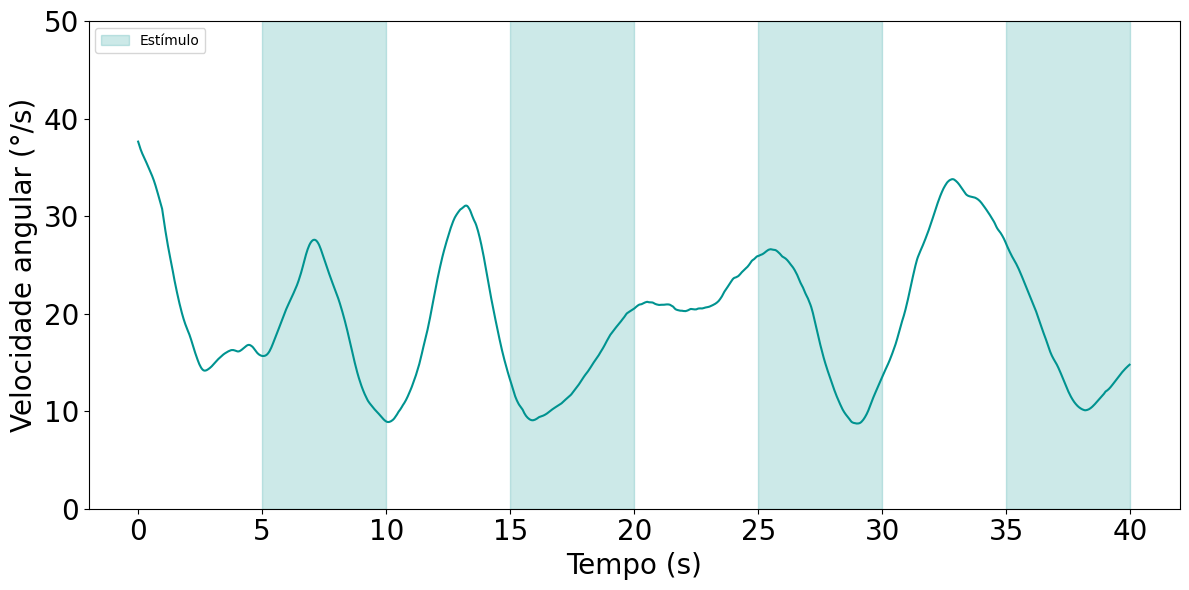

In [447]:
head_x_base_t1 = df_t1[df_t1['period'] == 'baseline'][('head', 'x')]
head_y_base_t1 = df_t1[df_t1['period'] == 'baseline'][('head', 'x')]
nose_x_base_t1 = df_t1[df_t1['period'] == 'baseline'][('nose', 'x')]
nose_y_base_t1 = df_t1[df_t1['period'] == 'baseline'][('nose', 'y')]    

vel_angular_base_t1 = ang_vel(head_x_base_t1, head_y_base_t1, nose_x_base_t1, nose_y_base_t1, fps=30, limiar_velocidade=90.0)
vel_angular_base_t1_mean = np.nanmean(vel_angular_base_t1)
print(f"Velocidade angular média no baseline do trial 1: {vel_angular_base_t1_mean:.2f} °/s")   
for i in trials:
    head_x = df_final[df_final['trial'] == i][('head', 'x')]
    head_y = df_final[df_final['trial'] == i][('head', 'y')]
    nose_x = df_final[df_final['trial'] == i][('nose', 'x')]
    nose_y = df_final[df_final['trial'] == i][('nose', 'y')]    
    
    vel_angular = ang_vel(head_x, head_y, nose_x, nose_y, fps=30, limiar_velocidade=90.0)
    vel_angular_mean = np.nanmean(vel_angular)
    print(f"Velocidade angular média no trial {i+1}: {vel_angular_mean:.2f} °/s")
    if i == 0:
        vel_angular_concat = vel_angular
        tempo_concat = np.arange(len(vel_angular)) / 30
    else:
        vel_angular_concat = np.concatenate((vel_angular_concat, vel_angular))
        tempo_concat = np.concatenate((tempo_concat, (np.arange(len(vel_angular)) / 30) + (i * 10)))
vel_angular_concat_mean = pd.Series(vel_angular_concat).rolling(window=59, min_periods=1, center=True).mean()
vel_angular_concat_mean_suave = vel_angular_concat_mean.rolling(window=59, min_periods=1, center=True).mean()
plt.figure(figsize=(12, 6))
plt.plot(tempo_concat, vel_angular_concat_mean_suave, color="#009390")
plt.axvspan(5, 10, color="#009390", alpha=0.2, label='Estímulo')
plt.axvspan(15, 20, color="#009390", alpha=0.2)
plt.axvspan(25, 30, color="#009390", alpha=0.2)
plt.axvspan(35, 40, color="#009390", alpha=0.2)
plt.xlabel('Tempo (s)', fontsize=20)
plt.ylabel('Velocidade angular (°/s)', fontsize=20)
plt.yticks([0, 10, 20, 30, 40, 50], fontsize=20)
plt.xticks(fontsize=20) 
plt.legend()
plt.tight_layout()

In [ ]:
angles_base = angles(head_x_base, head_y_base, nose_x_base, nose_y_base)
angles_stim = angles(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim)

print(f"Tempo baseline: {angles_base} seconds")
print(f"Tempo stim: {angles_stim} seconds")

deslocamento_baseline = total_displacement(df_baseline)
deslocamento_stim = total_displacement(df_stim)

print(f"Deslocamento (baseline): {deslocamento_baseline:.2f} cm")
print(f"Deslocamento (estímulo): {deslocamento_stim:.2f} cm")

fps = 30

stim_v = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps,  limiar_velocidade=90.0)
base_v = ang_vel(head_x_base, head_y_base, nose_x_base, nose_y_base, fps,  limiar_velocidade=90.0)

stim_mean = np.mean(stim_v)
base_mean = np.mean(base_v)

print(f"Velocidade angular média (baseline): {base_mean} °/s")
print(f"Velocidade angular média (estímulo): {stim_mean} °/s")

velocidade_media_baseline = calcular_velocidade_media(df_baseline, bodypart='body', fps=30)
velocidade_media_stim = calcular_velocidade_media(df_stim, bodypart='body', fps=30)

print(f"Velocidade média do corpo (baseline): {velocidade_media_baseline:.2f} cm/s")
print(f"Velocidade média do corpo (estímulo): {velocidade_media_stim:.2f} cm/s")

Tempo baseline: 2.033333333333333 seconds
Tempo stim: 2.1 seconds
Deslocamento (baseline): 3.83 cm
Deslocamento (estímulo): 6.68 cm
Velocidade angular média (baseline): 23.751948734923882 °/s
Velocidade angular média (estímulo): 13.76227713686947 °/s
Velocidade média do corpo (baseline): 0.77 cm/s
Velocidade média do corpo (estímulo): 1.34 cm/s


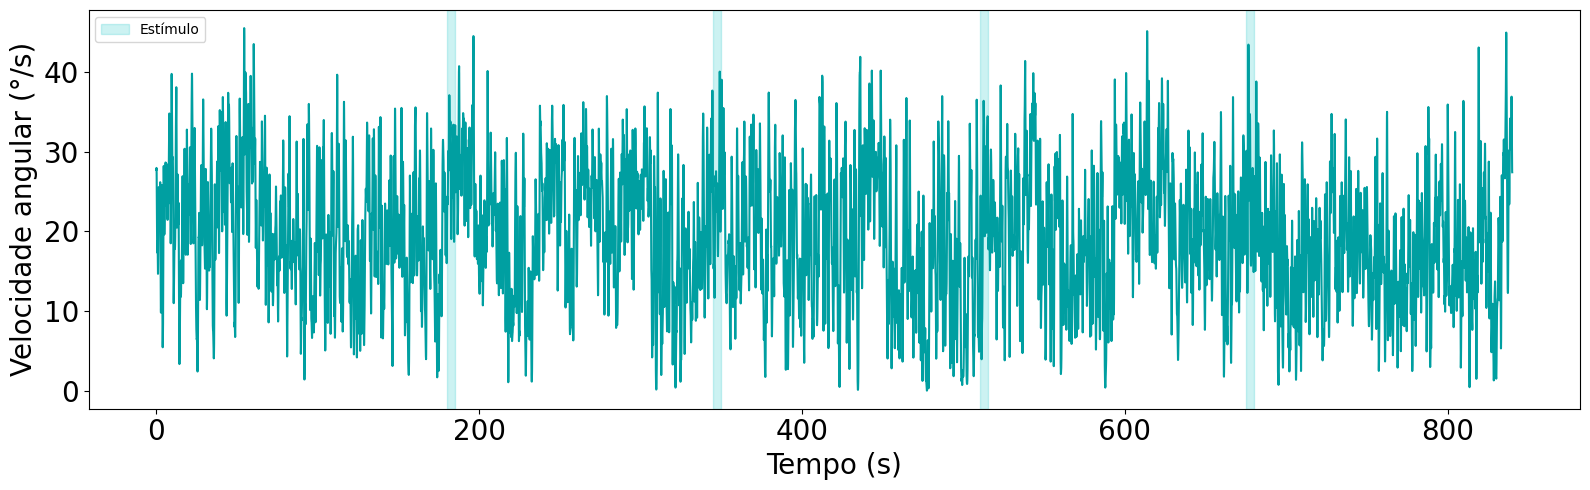

In [412]:
from scipy.ndimage import gaussian_filter1d

# Calcular a velocidade angular durante todo o vídeo

# Extrair coordenadas head e nose do dataframe original df
head_x_all = df[('head', 'x')].values
head_y_all = df[('head', 'y')].values
nose_x_all = df[('nose', 'x')].values
nose_y_all = df[('nose', 'y')].values

fps = 30  # taxa de quadros por segundo

# Calcular velocidade angular para todos os frames
vel_angular_all = ang_vel(head_x_all, head_y_all, nose_x_all, nose_y_all, fps)

# Criar vetor de tempo correspondente
tempo_all = np.arange(len(vel_angular_all)) / fps

# Suavizar a curva de velocidade angular usando filtro Gaussiano
vel_angular_suave = gaussian_filter1d(vel_angular_all, sigma=5)

plt.figure(figsize=(16, 5))
plt.plot(tempo_all, vel_angular_suave, color="#009FA1")
plt.yticks([0, 10, 20, 30, 40], fontsize=20)
plt.xticks(fontsize=20)

for i in range(len(stim_df)):
    plt.axvspan(
        stim_df['stim_ON'][i], 
        stim_df['stim_OFF'][i], 
        color="#00BFC2", 
        alpha=0.2, 
        label='Estímulo' if i == 0 else ""
    )

plt.xlabel('Tempo (s)', fontsize=20)
plt.ylabel('Velocidade angular (°/s)', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
percorra as trials = [0, 1, 2, 3], e junte os dados referentes a baseline e estímulo para cada trial calculando um sinal médio para a velocidade angular da cabeça nessa janela de 10 segundos, e plote no padrão ja seguido: plt.figure(figsize=(12, 6))
plt.plot(tempo_concat, vel_angular_concat_mean_suave, color="#009390")
plt.axvspan(5, 10, color="#009390", alpha=0.2, label='Estímulo')
plt.xlabel('Tempo (s)', fontsize=20)
plt.ylabel('Velocidade angular (°/s)', fontsize=20)
plt.yticks([0, 10, 20, 30, 40, 50], fontsize=20)
plt.xticks(fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
head_x_de_todos_estimulos = df_final[df_final['period'] == 'stimulus'][('head', 'x')]
display(head_x_de_todos_estimulos.head())

ang_vel(head_x, head_y, nose_x, nose_y, fps, limiar_velocidade=90.0)

In [ ]:
from scipy.ndimage import gaussian_filter1d

fps = 30
num_trials = 4
vel_angular_concat_all = []

for trial_idx in range(num_trials):
    # Seleciona os segmentos para cada trial
    df_seg_baseline = pd.DataFrame(stims_array[trial_idx], columns=baseline1_sorted.columns)
    df_seg_stim = pd.DataFrame(stims_array[trial_idx], columns=baseline1_sorted.columns)
    
    # Processa os dados
    df_baseline = process_tracking_data(
        df=df_seg_baseline,
        bodyparts=bodyparts,
        thresholds=thresholds,
        pix_per_cm=pix_per_cm,
        window_size=20
    )
    df_stim = process_tracking_data(
        df=df_seg_stim,
        bodyparts=bodyparts,
        thresholds=thresholds,
        pix_per_cm=pix_per_cm,
        window_size=20
    )
    
    head_x_base = df_baseline[('head', 'x')].values
    head_y_base = df_baseline[('head', 'y')].values
    nose_x_base = df_baseline[('nose', 'x')].values
    nose_y_base = df_baseline[('nose', 'y')].values
    
    head_x_stim = df_stim[('head', 'x')].values
    head_y_stim = df_stim[('head', 'y')].values     
    nose_x_stim = df_stim[('nose', 'x')].values
    nose_y_stim = df_stim[('nose', 'y')].values
    
    # Calcular a velocidade angular durante o trial
    vel_angular_trial = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps)
    
    # Suavizar a curva de velocidade angular usando filtro Gaussiano
    vel_angular_suave_trial = gaussian_filter1d(vel_angular_trial, sigma=5)
    
    # Calcular o tempo correspondente ao trial
    tempo_trial = np.arange(len(vel_angular_suave_trial)) / fps
    
    # Concatenar os resultados
    vel_angular_concat_all.append(vel_angular_suave_trial)

In [422]:
# 1. Pré-segmentação: Crie listas com os DataFrames de cada trial
baseline_trials = []
stim_trials = []

for i in range(num_trials):
    stim_start_sec = stim_df['stim_ON'].iloc[i]
    stim_end_sec = stim_df['stim_OFF'].iloc[i]
    baseline_start_sec = stim_start_sec - 5 # 5 segundos antes do estímulo
    
    # Converte tempos para frames
    baseline_start_frame = int(baseline_start_sec * fps)
    stim_start_frame = int(stim_start_sec * fps)
    stim_end_frame = int(stim_end_sec * fps)
    
    # Fatiar o DataFrame principal para obter os segmentos
    df_seg_baseline = df.iloc[baseline_start_frame:stim_start_frame]
    df_seg_stim = df.iloc[stim_start_frame:stim_end_frame]
    
    # Adiciona os DataFrames fatiados às listas
    baseline_trials.append(df_seg_baseline)
    stim_trials.append(df_seg_stim)

# --- Fim da pré-segmentação ---

vel_angular_concat_all = []

# 2. Agora, o seu loop principal vai funcionar
for trial_idx in range(num_trials):
    # Processa os dados usando o DataFrame correto da lista
    df_baseline_processed = process_tracking_data(
        df=baseline_trials[trial_idx],
        bodyparts=bodyparts, thresholds=thresholds, pix_per_cm=pix_per_cm, window_size=20
    )
    df_stim_processed = process_tracking_data(
        df=stim_trials[trial_idx],
        bodyparts=bodyparts, thresholds=thresholds, pix_per_cm=pix_per_cm, window_size=20
    )
    
    # Extrai coordenadas
    head_x_base, head_y_base = df_baseline_processed[('head', 'x')].values, df_baseline_processed[('head', 'y')].values
    nose_x_base, nose_y_base = df_baseline_processed[('nose', 'x')].values, df_baseline_processed[('nose', 'y')].values
    head_x_stim, head_y_stim = df_stim_processed[('head', 'x')].values, df_stim_processed[('head', 'y')].values
    nose_x_stim, nose_y_stim = df_stim_processed[('nose', 'x')].values, df_stim_processed[('nose', 'y')].values

    # Calcula as velocidades
    base_v, _ = ang_vel(head_x_base, head_y_base, nose_x_base, nose_y_base, fps)
    stim_v, _ = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps)
    
    # CORREÇÃO 2: Use np.concatenate para juntar os arrays
    vel_angular_concat = np.concatenate([base_v, stim_v])
    vel_angular_concat_all.append(vel_angular_concat)

# --- Parte final de Média e Plotagem (sem alterações) ---
vel_angular_concat_all = np.array(vel_angular_concat_all, dtype=float)
vel_angular_concat_mean = np.nanmean(vel_angular_concat_all, axis=0)
vel_angular_concat_mean_suave = gaussian_filter1d(vel_angular_concat_mean, sigma=10)
tempo_concat = np.arange(len(vel_angular_concat_mean)) / fps

plt.figure(figsize=(12, 6))
plt.plot(tempo_concat, vel_angular_concat_mean_suave, color="#009390")
plt.axvspan(5, 10, color="#009390", alpha=0.2, label='Estímulo')
plt.xlabel('Tempo (s)', fontsize=20)
plt.ylabel('Velocidade angular (°/s)', fontsize=20)
plt.yticks([0, 10, 20, 30, 40, 50], fontsize=20)
plt.xticks(fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: too many values to unpack (expected 2)

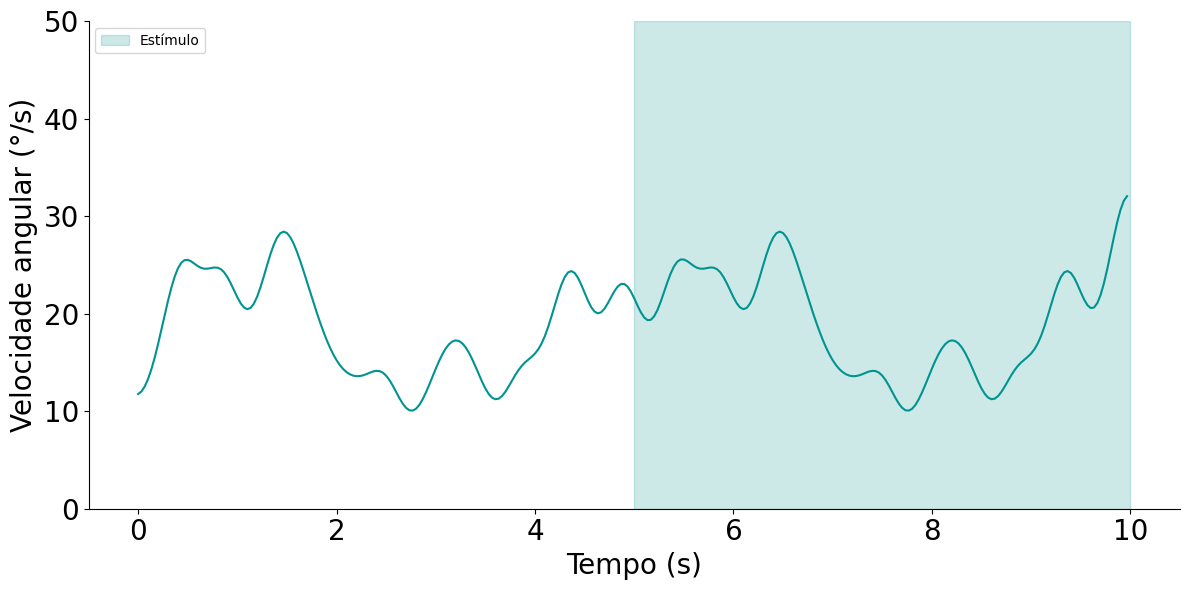

In [359]:
plt.figure(figsize=(12, 6))
plt.plot(tempo_concat, vel_angular_concat_mean_suave, color="#009390")
plt.axvspan(5, 10, color="#009390", alpha=0.2, label='Estímulo')
plt.xlabel('Tempo (s)', fontsize=20)
plt.ylabel('Velocidade angular (°/s)', fontsize=20)
plt.yticks([0, 10, 20, 30, 40, 50], fontsize=20)
plt.xticks(fontsize=20)
plt.legend()
plt.tight_layout()

# Remove as bordas do gráfico, mantendo apenas os eixos
ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()


In [ ]:
angles_base = angles(head_x_base, head_y_base, nose_x_base, nose_y_base)
angles_stim = angles(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim)

print(f"Tempo baseline: {angles_base} seconds")
print(f"Tempo stim: {angles_stim} seconds")

deslocamento_baseline = total_displacement(df_baseline)
deslocamento_stim = total_displacement(df_stim)

print(f"Deslocamento (baseline): {deslocamento_baseline:.2f} cm")
print(f"Deslocamento (estímulo): {deslocamento_stim:.2f} cm")

fps = 30

stim_v = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps,  limiar_velocidade=90.0)
base_v = ang_vel(head_x_base, head_y_base, nose_x_base, nose_y_base, fps,  limiar_velocidade=90.0)

stim_mean = np.mean(stim_v)
base_mean = np.mean(base_v)

print(f"Velocidade angular média (baseline): {base_mean} °/s")
print(f"Velocidade angular média (estímulo): {stim_mean} °/s")

velocidade_media_baseline = calcular_velocidade_media(df_baseline, bodypart='body', fps=30)
velocidade_media_stim = calcular_velocidade_media(df_stim, bodypart='body', fps=30)

print(f"Velocidade média do corpo (baseline): {velocidade_media_baseline:.2f} cm/s")
print(f"Velocidade média do corpo (estímulo): {velocidade_media_stim:.2f} cm/s")

Tempo baseline: 5.0 seconds
Tempo stim: 5.0 seconds
Deslocamento (baseline): 5.29 cm
Deslocamento (estímulo): 5.55 cm
Velocidade angular média (baseline): 7.504604299353364 °/s
Velocidade angular média (estímulo): 23.57861632484699 °/s
Velocidade média do corpo (baseline): 1.06 cm/s
Velocidade média do corpo (estímulo): 1.11 cm/s


In [ ]:
angles_base = angles(head_x_base, head_y_base, nose_x_base, nose_y_base)
angles_stim = angles(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim)

print(f"Tempo baseline: {angles_base} seconds")
print(f"Tempo stim: {angles_stim} seconds")

deslocamento_baseline = total_displacement(df_baseline)
deslocamento_stim = total_displacement(df_stim)

print(f"Deslocamento (baseline): {deslocamento_baseline:.2f} cm")
print(f"Deslocamento (estímulo): {deslocamento_stim:.2f} cm")

fps = 30

stim_v = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps,  limiar_velocidade=90.0)
base_v = ang_vel(head_x_base, head_y_base, nose_x_base, nose_y_base, fps,  limiar_velocidade=90.0)

stim_mean = np.mean(stim_v)
base_mean = np.mean(base_v)

print(f"Velocidade angular média (baseline): {base_mean} °/s")
print(f"Velocidade angular média (estímulo): {stim_mean} °/s")

velocidade_media_baseline = calcular_velocidade_media(df_baseline, bodypart='body', fps=30)
velocidade_media_stim = calcular_velocidade_media(df_stim, bodypart='body', fps=30)

print(f"Velocidade média do corpo (baseline): {velocidade_media_baseline:.2f} cm/s")
print(f"Velocidade média do corpo (estímulo): {velocidade_media_stim:.2f} cm/s")

Tempo baseline: 5.0 seconds
Tempo stim: 5.0 seconds
Deslocamento (baseline): 5.29 cm
Deslocamento (estímulo): 5.55 cm
Velocidade angular média (baseline): 7.504604299353364 °/s
Velocidade angular média (estímulo): 23.57861632484699 °/s
Velocidade média do corpo (baseline): 1.06 cm/s
Velocidade média do corpo (estímulo): 1.11 cm/s


### Plots

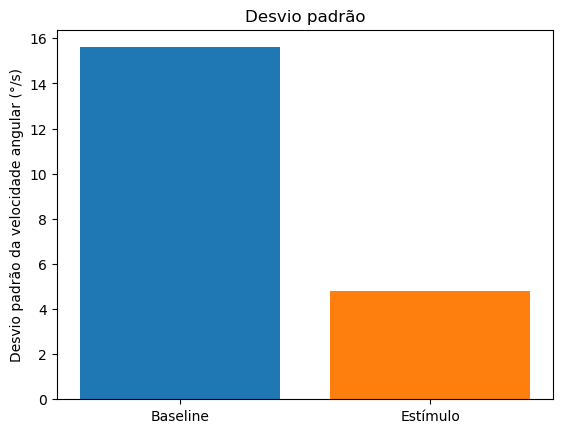

In [35]:
fps = 30

stim_v = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps)
base_v = ang_vel(head_x_base, head_y_base, nose_x_base, nose_y_base, fps)

stds = [np.std(base_v), np.std(stim_v)]
labels = ['Baseline', 'Estímulo']

plt.bar(labels, stds, color=['tab:blue', 'tab:orange'])
plt.ylabel('Desvio padrão da velocidade angular (°/s)')
plt.title('Desvio padrão')
plt.show()

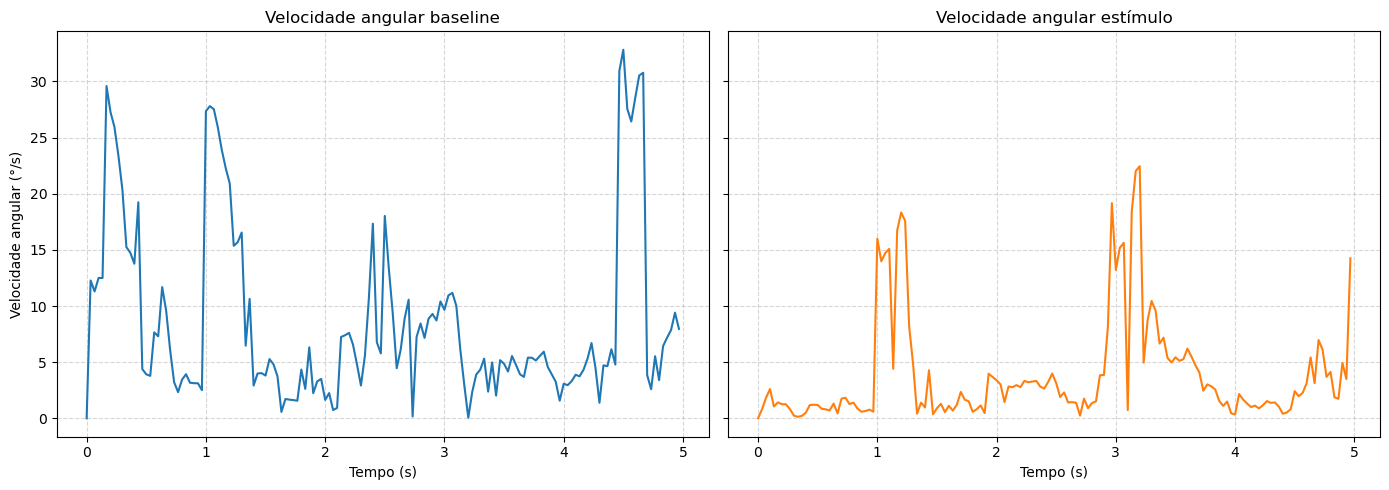

In [188]:
fps = 30

tempo_stim = np.arange(len(stim_v)) / fps
tempo_base = np.arange(len(base_v)) / fps

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].plot(tempo_base, base_v, color='tab:blue')
axs[0].set_title('Velocidade angular baseline')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Velocidade angular (°/s)')
axs[0].grid(True, linestyle='--', alpha=0.5)

axs[1].plot(tempo_stim, stim_v, color='tab:orange')
axs[1].set_title('Velocidade angular estímulo')
axs[1].set_xlabel('Tempo (s)')
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

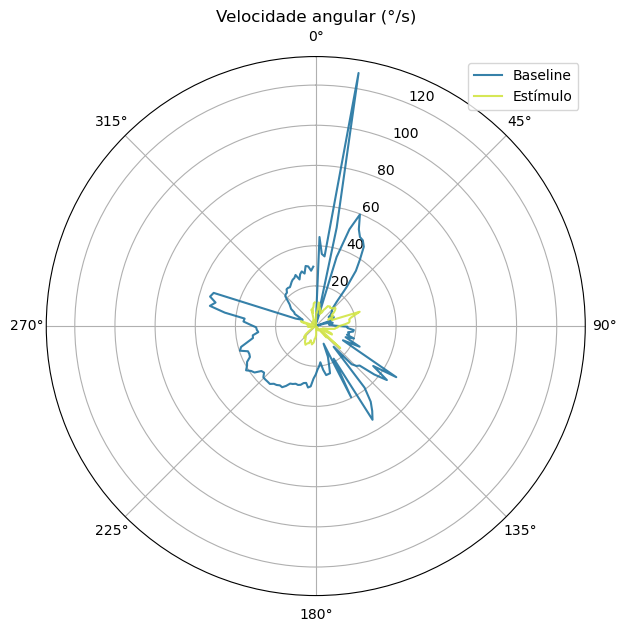

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'})

# Ângulos para o plot polar (em radianos)
angles_stim = np.linspace(0, 2 * np.pi, len(stim_v), endpoint=False)
angles_base = np.linspace(0, 2 * np.pi, len(base_v), endpoint=False)

# Plot das velocidades angulares no polar
ax.plot(angles_base, np.abs(base_v), label='Baseline', color="#2073A0", alpha=0.9)
ax.plot(angles_stim, np.abs(stim_v), label='Estímulo', color="#D2E543", alpha=0.9)

ax.set_title('Velocidade angular (°/s)')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper right')
plt.show()